# Preamble

## Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

## Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpltern
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.dissimilarity import load_dmat_as_pickle
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import lib.thisproject.data

## Set Style

In [5]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 200

In [6]:
genome_type_palette = {
    "SPGC": "tab:green",
    "MAG": "tab:orange",
    "Isolate": "tab:blue",
    "Ref": "black",
}

# Data Setup

## Metadata

In [7]:
species_list = (
    pd.read_table("meta/species_group.tsv")[lambda x: x.species_group_id == "hmp2"]
    .species_id.astype(str)
    .unique()
)

In [8]:
def parse_taxonomy_string(taxonomy_string):
    values = taxonomy_string.split(";")
    return pd.Series(values, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])

In [9]:
species_taxonomy_inpath = "ref/uhgg_genomes_all_v2.tsv"

species_taxonomy = (
    pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]
    .assign(species_id=lambda x: "1" + x.MGnify_accession.str.split("-").str[2])
    .set_index("species_id")
    .Lineage.apply(parse_taxonomy_string)
)
species_taxonomy

/tmp/bsmith/ipykernel_930387/4268967817.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]


d__                p__                     c__  \
species_id                                                           
100001      d__Bacteria    p__Firmicutes_A           c__Clostridia   
100002      d__Bacteria    p__Firmicutes_A           c__Clostridia   
100003      d__Bacteria    p__Bacteroidota          c__Bacteroidia   
100004      d__Bacteria    p__Firmicutes_A           c__Clostridia   
100005      d__Bacteria    p__Firmicutes_A           c__Clostridia   
...                 ...                ...                     ...   
104640      d__Bacteria    p__Bacteroidota          c__Bacteroidia   
104641      d__Bacteria  p__Proteobacteria  c__Gammaproteobacteria   
104642      d__Bacteria    p__Firmicutes_A           c__Clostridia   
104643      d__Bacteria    p__Firmicutes_A           c__Clostridia   
104644      d__Bacteria    p__Firmicutes_A           c__Clostridia   

                                o__                       f__  \
species_id                                                      
100001      o__Peptostreptococcales  f__Peptostreptococcaceae   
100002            o__Lachnospirales        f__Lachnospiraceae   
100003             o__Bacteroidales          f__Rikenellaceae   
100004           o__Oscillospirales        f__Ruminococcaceae   
100005      o__Peptostreptococcales  f__Peptostreptococcaceae   
...                             ...                       ...   
104640             o__Bacteroidales         f__Bacteroidaceae   
104641           o__Burkholderiales       f__Burkholderiaceae   
104642            o__Lachnospirales                       f__   
104643           o__Oscillospirales     f__Acutalibacteraceae   
104644           o__Oscillospirales        f__Ruminococcaceae   

                            g__                               s__  
species_id                                                         
100001         g__GCA-900066495                               s__  
100002             g__Blautia_A          s__Blautia_A sp900066165  
100003             g__Alistipes               s__Alistipes shahii  
100004         g__Anaerotruncus      s__Anaerotruncus colihominis  
100005      g__Terrisporobacter  s__Terrisporobacter glycolicus_A  
...                         ...                               ...  
104640            g__Prevotella                               s__  
104641            g__Sutterella                               s__  
104642                      g__                               s__  
104643         g__Eubacterium_R      s__Eubacterium_R sp003526845  
104644      g__Negativibacillus                               s__  

[4644 rows x 7 columns]

p__Euryarchaeota (0.49999999999999956, 0.0, 1.0)
p__Thermoplasmatota (0.4762434743766357, 0.43561560482888373, 0.8118718682762947)
p__Firmicutes (0.13730663956330513, 0.48846903076532633, 1.0)
p__Firmicutes_A (0.2313124726048037, 0.5864780640600611, 0.6939374178144111)
p__Firmicutes_C (0.03269207045110534, 0.9999999999999998, 1.0)
p__Actinobacteriota (0.4723724756649227, 0.8241241585549742, 0.7293059019107313)
p__Synergistota (0.5039025959761778, 1.0, 0.7049219497439101)
p__Fusobacteriota (0.7159995965199522, 0.8931657578847765, 0.6794972736543294)
p__Campylobacterota (0.9433756729740642, 1.0, 0.3660254037844388)
p__Proteobacteria (0.8446027625105776, 0.6948742813072231, 0.5338082875317327)
p__Desulfobacterota_A (0.9999999999999999, 0.49465584339977886, 0.25584277759443574)
p__Bacteroidota (0.7822498041325509, 0.4101711929297688, 0.34674941239765256)
p__Verrucomicrobiota (1.0, 0.0, 0.0)
p__Euryarchaeota (0.49999999999999956, 0.0, 1.0)
p__Thermoplasmatota (0.4762434743766357, 0.43561560

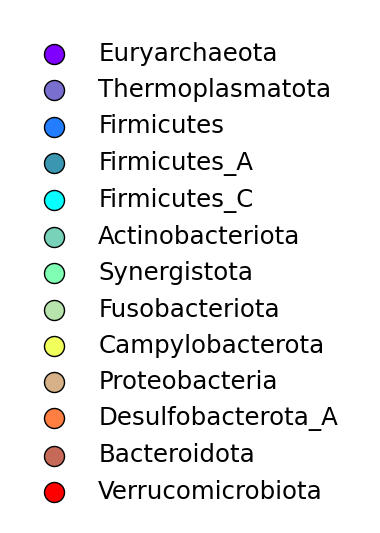

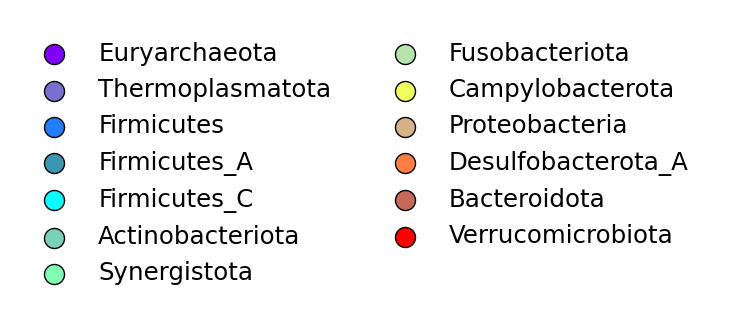

In [10]:
phylum_order = [
    "p__Euryarchaeota",
    "p__Thermoplasmatota",
    "p__Firmicutes",
    "p__Firmicutes_A",
    "p__Firmicutes_C",
    # "p__Firmicutes_B", # None in species_list1
    # "p__Firmicutes_G", # B/G/I not sure how related to C or A
    # "p__Firmicutes_I", #
    # "p__Cyanobacteria", # None in species_list1
    "p__Actinobacteriota",
    "p__Synergistota",
    "p__Fusobacteriota",
    "p__Campylobacterota",
    "p__Proteobacteria",
    "p__Desulfobacterota_A",
    "p__Bacteroidota",
    "p__Verrucomicrobiota",
    # "dummy0", # 18
    # "dummy1", # 19
    # "dummy2", # 20
]

phylum_palette = lib.plot.construct_ordered_palette(
    phylum_order,
    cm="rainbow",
    desaturate_levels=[1.0, 0.5],
)

fig = plt.figure(figsize=(2, 3), facecolor="none")
for p__ in phylum_order:
    print(p__, phylum_palette[p__])
    plt.scatter(
        [],
        [],
        color=phylum_palette[p__],
        lw=0.5,
        edgecolor="k",
        label=p__.replace("p__", ""),
    )
plt.legend(ncols=1, markerscale=1.5, frameon=False)
lib.plot.hide_axes_and_spines()
fig.savefig("fig/fig2_phylum_legend.pdf")

fig = plt.figure(figsize=(2, 1.5), facecolor="none")
for p__ in phylum_order:
    print(p__, phylum_palette[p__])
    plt.scatter(
        [],
        [],
        color=phylum_palette[p__],
        lw=0.5,
        edgecolor="k",
        label=p__.replace("p__", ""),
    )
plt.legend(ncols=2, markerscale=1.5, frameon=False)
lib.plot.hide_axes_and_spines()
fig.savefig("fig/fig4_phylum_legend_2col.pdf")


# assert len(set(phylum_palette.values())) == len((phylum_palette.values()))

In [11]:
mgen = pd.read_table("meta/hmp2/mgen.tsv", index_col="library_id")
preparation = pd.read_table("meta/hmp2/preparation.tsv", index_col="preparation_id")
stool = pd.read_table("meta/hmp2/stool.tsv", index_col="stool_id")
visit = pd.read_table("meta/hmp2/visit.tsv", index_col="visit_id")
subject = pd.read_table("meta/hmp2/subject.tsv", index_col="subject_id")

meta_all = (
    mgen.join(preparation.drop(columns="library_type"), on="preparation_id")
    .join(stool, on="stool_id")
    .join(visit, on="visit_id", rsuffix="_")
    .join(subject, on="subject_id")
    .assign(
        new_name=lambda x: (
            x[["subject_id", "week_number"]]
            .assign(library_id=x.index)
            .assign(week_number=lambda x: x.week_number.fillna(999).astype(int))
            .apply(lambda x: "_".join(x.astype(str)), axis=1)
        )
    )
    # .reset_index()
    # .set_index('new_name')
)

library_id_to_new_name = meta_all.new_name

assert not any(meta_all.subject_id.isna())

# TODO: Rename samples based on subject and visit number
# TODO: Drop duplicate stools

## Species Depth

In [12]:
species_depth = []
_missing_species = []

for species in tqdm(species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95.species_depth.tsv"
    if not os.path.exists(inpath):
        _missing_species.append(species)
        continue
    data = pd.read_table(inpath, names=["sample", "depth"]).assign(species=species)
    species_depth.append(data)
species_depth = (
    pd.concat(species_depth)
    .set_index(["sample", "species"])
    .depth.unstack(fill_value=0)
)

print(
    len(_missing_species),
    "out of",
    len(species_list),
    "species are missing.",
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:12<00:00, 48.28it/s]


0 out of 627 species are missing.


In [13]:
depth_thresh = 0.2

species_found = species_depth > depth_thresh
species_prevalence = (
    species_found.groupby(meta_all.subject_id).any().mean().sort_values(ascending=False)
)

species_rabund_when_found = species_depth.divide(species_depth.sum(1), axis=0).where(
    species_found, np.nan
)
species_mean_rabund_when_found = (
    species_rabund_when_found.groupby(meta_all.subject_id)
    .mean()
    .mean()
    .sort_values(ascending=False)
)
species_median_rabund_when_found = (
    species_rabund_when_found.groupby(meta_all.subject_id)
    .median()
    .median()
    .sort_values(ascending=False)
)

species_prevalence.to_frame("prevalence").assign(
    mean_rabund=species_mean_rabund_when_found,
    median_rabund=species_median_rabund_when_found,
).join(species_taxonomy).head(20)

prevalence  mean_rabund  median_rabund          d__  \
species                                                        
101345     0.971698     0.015968       0.007896  d__Bacteria   
101378     0.962264     0.027595       0.012972  d__Bacteria   
102478     0.962264     0.162656       0.137527  d__Bacteria   
101300     0.943396     0.020052       0.010758  d__Bacteria   
102545     0.943396     0.023713       0.008445  d__Bacteria   
102492     0.933962     0.043301       0.022242  d__Bacteria   
102528     0.933962     0.006703       0.003563  d__Bacteria   
102549     0.933962     0.011088       0.006721  d__Bacteria   
100196     0.933962     0.012013       0.004226  d__Bacteria   
101346     0.933962     0.077860       0.056808  d__Bacteria   
101338     0.933962     0.003837       0.001703  d__Bacteria   
102272     0.924528     0.031332       0.013002  d__Bacteria   
102327     0.924528     0.005060       0.003054  d__Bacteria   
100099     0.915094     0.006474       0.003432  d__Bacteria   
100022     0.905660     0.018995       0.010851  d__Bacteria   
100251     0.896226     0.006890       0.003227  d__Bacteria   
100029     0.896226     0.004113       0.001500  d__Bacteria   
102438     0.886792     0.032567       0.018244  d__Bacteria   
103681     0.867925     0.049747       0.011281  d__Bacteria   
102506     0.858491     0.025264       0.002860  d__Bacteria   

                       p__                     c__                  o__  \
species                                                                   
101345     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
101378     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
102478     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
101300     p__Firmicutes_A           c__Clostridia   o__Oscillospirales   
102545     p__Firmicutes_A           c__Clostridia   o__Oscillospirales   
102492     p__Firmicutes_A           c__Clostridia    o__Lachnospirales   
102528     p__Firmicutes_A           c__Clostridia    o__Lachnospirales   
102549     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
100196     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
101346     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
101338     p__Firmicutes_A           c__Clostridia    o__Lachnospirales   
102272     p__Firmicutes_A           c__Clostridia   o__Oscillospirales   
102327     p__Firmicutes_A           c__Clostridia   o__Oscillospirales   
100099     p__Firmicutes_A           c__Clostridia   o__Oscillospirales   
100022     p__Firmicutes_A           c__Clostridia   o__Oscillospirales   
100251     p__Firmicutes_A           c__Clostridia    o__Lachnospirales   
100029     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
102438     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
103681     p__Bacteroidota          c__Bacteroidia     o__Bacteroidales   
102506   p__Proteobacteria  c__Gammaproteobacteria  o__Enterobacterales   

                           f__                  g__  \
species                                               
101345       f__Bacteroidaceae       g__Bacteroides   
101378       f__Bacteroidaceae       g__Bacteroides   
102478       f__Bacteroidaceae     g__Bacteroides_B   
101300      f__Ruminococcaceae  g__Faecalibacterium   
102545      f__Ruminococcaceae  g__Faecalibacterium   
102492      f__Lachnospiraceae      g__Agathobacter   
102528      f__Lachnospiraceae      g__Anaerostipes   
102549       f__Bacteroidaceae       g__Bacteroides   
100196       f__Bacteroidaceae       g__Bacteroides   
101346       f__Bacteroidaceae       g__Bacteroides   
101338      f__Lachnospiraceae         g__Blautia_A   
102272      f__Ruminococcaceae  g__Faecalibacterium   
102327     f__Oscillospiraceae     g__Oscillibacter   
100099     f__Oscillospiraceae    g__Flavonifractor   
100022      f__Ruminococcaceae  g__Faecalibacterium   
100251      f_

## Strain Statistics

In [14]:
def classify_genome(x):
    if (x.genome_type == "Isolate") & x.passes_filter:
        return "isolate"
    elif (x.genome_type == "Isolate") & ~x.passes_filter:
        return "isolate_fails_qc"
    elif (x.genome_type == "MAG") & x.passes_filter:
        return "mag"
    elif (x.genome_type == "MAG") & ~x.passes_filter:
        return "mag_fails_qc"
    elif (x.genome_type == "SPGC") & x.passes_filter:
        return "spgc"
    elif (x.genome_type == "SPGC") & x.passes_geno_positions:
        return "sfacts_only"
    elif (x.genome_type == "SPGC") & ~(x.passes_geno_positions):
        return "sfacts_fails_qc"
    else:
        raise ValueError("Genome did not match classification criteria:", x)

In [15]:
filt_stats = []
missing_species = []

_species_list = species_list
# _species_list = ["100003"]

for species in tqdm(_species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    data = pd.read_table(inpath).assign(species=species, inpath=inpath)
    filt_stats.append(data)
filt_stats = (
    pd.concat(filt_stats)
    .assign(
        genome_class=lambda x: x.apply(classify_genome, axis=1),
        species_strain=lambda x: x.species + "_" + x.genome_id,
    )
    .set_index("species_strain")
)


print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:01<00:00, 367.06it/s]


11 out of 627 species are missing stats.


# Analysis

## How many strains and species were detected at each filtering level.

In [16]:
# Define different subsets of the species:

# All species:
# species_list
spgc_strain_list = filt_stats[lambda x: x.genome_type.isin(["SPGC"])].index.values

# All species with enough positions
species_list0 = filt_stats[lambda x: x.passes_geno_positions].species.unique()
spgc_strain_list0 = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list0)
].index.values

# All species with sf strains
species_list1 = filt_stats[
    lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
].species.unique()
spgc_strain_list1 = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list1)
].index.values

# All species with sf strains to talk about distributions (>=10)
species_list1b = idxwhere(
    filt_stats[
        lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 10
)
spgc_strain_list1b = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list1b)
].index.values

# All species with spgc strains
species_list2 = filt_stats[
    lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
].species.unique()
spgc_strain_list2 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list2)
].index.values

# All species with enough spgc strains for pangenome analysis (>=10)
species_list3 = idxwhere(
    filt_stats[
        lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 10
)
spgc_strain_list3 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list3)
].index.values

# Species with large numbers of strains (>=20)
species_list4 = idxwhere(
    filt_stats[
        lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 20
)
spgc_strain_list4 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list4)
].index.values

_species_list_map = {
    "All considered species": (species_list, spgc_strain_list),
    "0: Species with enough genotyped positions": (species_list0, spgc_strain_list0),
    "1: With sfacts strains": (species_list1, spgc_strain_list1),
    "1b: With (>=10) sfacts strains": (species_list1b, spgc_strain_list1b),
    "2: With SPGC inferences": (species_list2, spgc_strain_list2),
    "3: With >=10 inferences": (species_list3, spgc_strain_list3),
    "4: With >=20 inferences": (species_list4, spgc_strain_list4),
}
for _species_list_name, (_species_list, _strain_list) in _species_list_map.items():
    print(_species_list_name, len(_species_list), len(_strain_list))
    print(species_taxonomy.loc[_species_list].p__.value_counts())
    print()

All considered species 627 11264
p__
p__Firmicutes_A          310
p__Bacteroidota           97
p__Firmicutes             77
p__Proteobacteria         45
p__Actinobacteriota       40
p__Firmicutes_C           32
p__Verrucomicrobiota      10
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Spirochaetota           1
p__Campylobacterota        1
Name: count, dtype: int64

0: Species with enough genotyped positions 616 10962
p__
p__Firmicutes_A          308
p__Bacteroidota           97
p__Firmicutes             76
p__Proteobacteria         45
p__Actinobacteriota       34
p__Firmicutes_C           31
p__Verrucomicrobiota      10
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Campylobacterota        1
Name: count, dtype: int64

1: With sfacts strains 601 10962
p__
p__Firmicutes_A          304
p__

In [17]:
# Supplementary Table 1
d = filt_stats.loc[spgc_strain_list2][
    [
        "species",
        "num_gene",
        "num_strain_sample",
        "sum_strain_depth",
        "species_gene_frac",
        "log_selected_gene_depth_ratio_std",
        "num_geno_positions",
    ]
].astype(dict(num_gene=int, num_strain_sample=int, num_geno_positions=int))
d.to_csv("fig/hmp2_inferred_strains_supplementary_table1.tsv", sep="\t")
d

species  num_gene  num_strain_sample  sum_strain_depth  \
species_strain                                                          
100003_1        100003      4223                 32         67.479430   
100003_11       100003      4415                 11         38.757370   
100003_12       100003      4958                 24        137.793998   
100003_131      100003      3870                  6          9.341718   
100003_15       100003      3266                  3          9.642769   
...                ...       ...                ...               ...   
104644_25       104644      2622                  7          7.576239   
104644_32       104644      2671                 16         11.667976   
104644_4        104644      2678                 12         30.883148   
104644_5        104644      2609                  2         11.305921   
104644_6        104644      2687                 12         41.661616   

                species_gene_frac  log_selected_gene_depth_ratio_std  \
species_strain                                                         
100003_1                 0.993340                           0.208484   
100003_11                0.989534                           0.206089   
100003_12                0.994291                           0.206487   
100003_131               0.951475                           0.208321   
100003_15                0.955281                           0.202516   
...                           ...                                ...   
104644_25                0.992126                           0.170359   
104644_32                0.991410                           0.181377   
104644_4                 0.998568                           0.164904   
104644_5                 0.999284                           0.163263   
104644_6                 1.000000                           0.157339   

                num_geno_positions  
species_strain                      
100003_1                       975  
100003_11                      823  
100003_12                      994  
100003_131                     966  
100003_15                      888  
...                            ...  
104644_25                    16155  
104644_32                     7748  
104644_4                     96297  
104644_5                      7875  
104644_6                     30380  

[3511 rows x 7 columns]

[(0, 0), (241, 1), (375, 2), (775, 4), (1427, 8), (572, 16), (98, 32), (21, 64), (2, 128)]
0.25     5.0
0.50     9.0
0.75    13.0
Name: num_strain_sample, dtype: float64


Text(0, 0.5, 'Strains (count)')

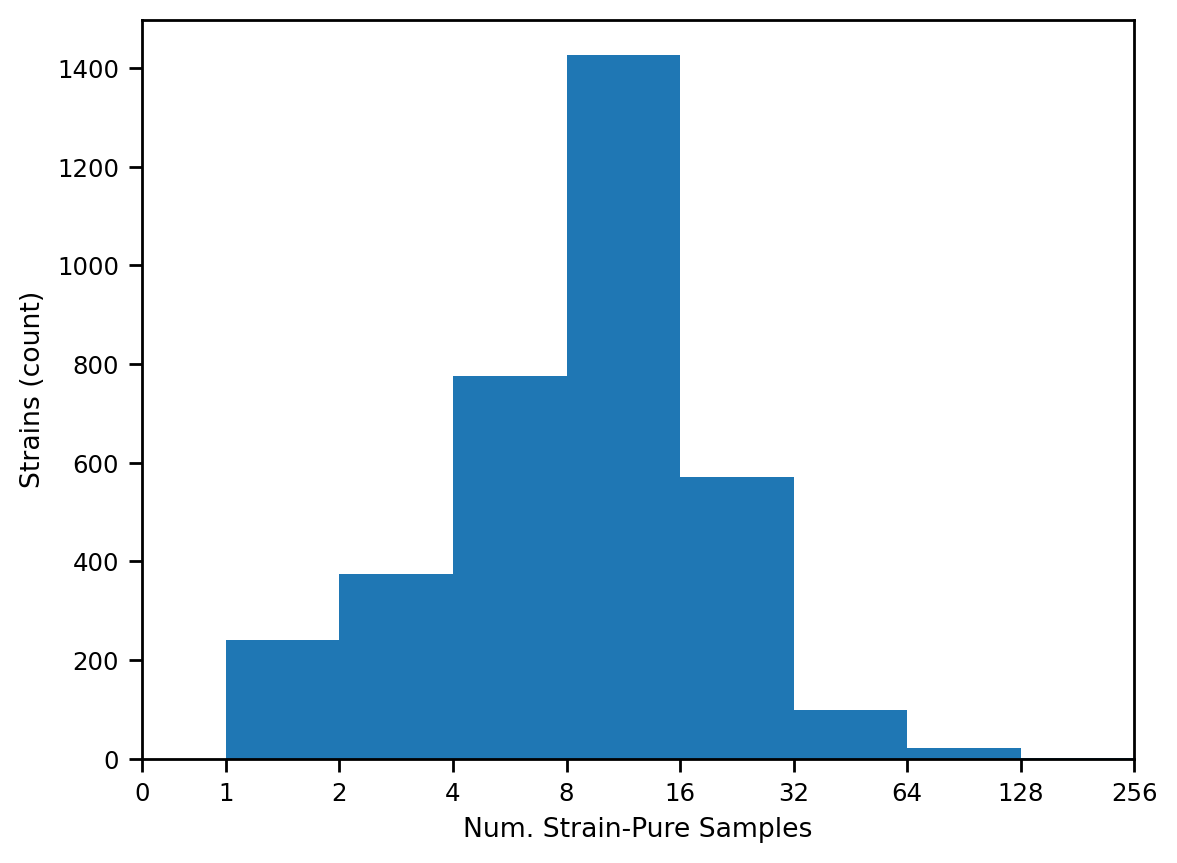

In [18]:
d = filt_stats.loc[spgc_strain_list2][
    [
        "species",
        "num_gene",
        "num_strain_sample",
        "sum_strain_depth",
        "species_gene_frac",
        "log_selected_gene_depth_ratio_std",
        "num_geno_positions",
    ]
].astype(dict(num_gene=int, num_strain_sample=int, num_geno_positions=int))

bins = [0] + list(np.logspace(0, 8, base=2, num=9).astype(int))

print(list(zip(*np.histogram(d.num_strain_sample, bins=bins))))
print(d.num_strain_sample.quantile([0.25, 0.5, 0.75]))
plt.hist(d.num_strain_sample, bins=bins, histtype="bar")
plt.xlim(0, 256)
plt.xscale("symlog", linthresh=1, linscale=0.2)
plt.xticks(ticks=bins, labels=bins)
plt.xticks(ticks=[], labels=[], minor=True)
plt.xlabel("Num. Strain-Pure Samples")
plt.ylabel("Strains (count)")

### Figure 3E

In [19]:
# Annotations for Figure 3 species tree:
filt_stats.loc[spgc_strain_list2].species.value_counts().to_csv(
    "fig/hmp2_spgc_strain_counts.tsv", sep="\t", header=True
)

In [20]:
diss_stats = []
missing_species = []

_species_list = species_list2
# _species_list = ["100003"]

for species in tqdm(_species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_diss_spgc_and_ref.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    data = pd.read_table(inpath).assign(species=species, inpath=inpath)
    diss_stats.append(data)
diss_stats = (
    pd.concat(diss_stats)
    .set_index(["species", "genome_id"])
    .join(filt_stats.set_index(["species", "genome_id"]), rsuffix="_b")
    .reset_index()
    .assign(
        species_strain=lambda x: x.species + "_" + x.genome_id,
    )
    .set_index("species_strain")
)

print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing.",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:03<00:00, 141.40it/s]


0 out of 443 species are missing.


## How many Archaea (+Bacteria)

In [21]:
filt_stats.loc[spgc_strain_list2].join(species_taxonomy, on="species")[
    lambda x: (x.d__ == "d__Archaea")
]

genome_id  num_gene  num_strain_sample  sum_strain_depth  \
species_strain                                                            
102160_2               2    1734.0               17.0         22.128278   
102160_4               4    1713.0               17.0          7.840082   
102160_5               5    1661.0               10.0         50.940101   
102163_0               0    1770.0               10.0         17.712570   
102163_2               2    1705.0               18.0        132.456752   
102163_20             20    1702.0                8.0          6.814720   
104339_2               2    2178.0                4.0         15.899136   

                max_strain_depth  species_gene_frac  \
species_strain                                        
102160_2                2.529925           0.999136   
102160_4                1.444874           0.986171   
102160_5                8.131988           0.990493   
102163_0                7.121078           0.983141   
102163_2               55.523398           0.993789   
102163_20               2.640634           0.960071   
104339_2                7.144329           1.000000   

                log_selected_gene_depth_ratio_std  num_geno_positions  \
species_strain                                                          
102160_2                                 0.096884             15649.0   
102160_4                                 0.122069             15488.0   
102160_5                                 0.091316              2525.0   
102163_0                                 0.181465             15851.0   
102163_2                                 0.185900             14399.0   
102163_20                                0.196597              1394.0   
104339_2                                 0.193347             58928.0   

                strain_metagenotype_entropy genome_type  ...  species  \
species_strain                                           ...            
102160_2                           0.004262        SPGC  ...   102160   
102160_4                           0.001392        SPGC  ...   102160   
102160_5                           0.000356        SPGC  ...   102160   
102163_0                           0.001141        SPGC  ...   102163   
102163_2                           0.000835        SPGC  ...   102163   
102163_20                          0.000000        SPGC  ...   102163   
104339_2                           0.000659        SPGC  ...   104339   

                                                           inpath  \
species_strain                                                      
102160_2        data/group/hmp2/species/sp-102160/r.proc.gtpro...   
102160_4        data/group/hmp2/species/sp-102160/r.proc.gtpro...   
102160_5        data/group/hmp2/species/sp-102160/r.proc.gtpro...   
102163_0        data/group/hmp2/species/sp-102163/r.proc.gtpro...   
102163_2        data/group/hmp2/species/sp-102163/r.proc.gtpro...   
102163_20       data/group/hmp2/species/sp-102163/r.proc.gtpro...   
104339_2        data/group/hmp2/species/sp-104339/r.proc.gtpro...   

               genome_class         d__                  p__  \
species_strain                                                 
102160_2               spgc  d__Archaea  p__Thermoplasmatota   
102160_4               spgc  d__Archaea  p__Thermoplasmatota   
102160_5               spgc  d__Archaea  p__Thermoplasmatota   
102163_0               spgc  d__Archaea     p__Euryarchaeota   
102163_2               spgc  d__Archaea     p__Euryarchaeota   
102163_20              spgc  d__Archaea     p__Euryarchaeota   
104339_2               spgc  d__Archaea  p__Thermoplasmatota   

                               c__                         o__  \
species_strain                                                   
102160_2         c__Thermoplasmata  o__Methanomassiliicoccales   
102160_4         c__Thermoplasmata  o__Methanomassiliicoccales   
102160_5         c__Thermoplasmata  o__Methanomassiliicoccales  

In [22]:
filt_stats.loc[spgc_strain_list2].join(species_taxonomy, on="species")[
    lambda x: (x.d__ == "d__Bacteria")
]

genome_id  num_gene  num_strain_sample  sum_strain_depth  \
species_strain                                                            
100003_1               1    4223.0               32.0         67.479430   
100003_11             11    4415.0               11.0         38.757370   
100003_12             12    4958.0               24.0        137.793998   
100003_131           131    3870.0                6.0          9.341718   
100003_15             15    3266.0                3.0          9.642769   
...                  ...       ...                ...               ...   
104644_25             25    2622.0                7.0          7.576239   
104644_32             32    2671.0               16.0         11.667976   
104644_4               4    2678.0               12.0         30.883148   
104644_5               5    2609.0                2.0         11.305921   
104644_6               6    2687.0               12.0         41.661616   

                max_strain_depth  species_gene_frac  \
species_strain                                        
100003_1                8.080942           0.993340   
100003_11               7.863981           0.989534   
100003_12              15.854294           0.994291   
100003_131              2.655639           0.951475   
100003_15               3.657061           0.955281   
...                          ...                ...   
104644_25               3.919859           0.992126   
104644_32               3.327311           0.991410   
104644_4                4.569362           0.998568   
104644_5               11.192343           0.999284   
104644_6               16.952418           1.000000   

                log_selected_gene_depth_ratio_std  num_geno_positions  \
species_strain                                                          
100003_1                                 0.208484               975.0   
100003_11                                0.206089               823.0   
100003_12                                0.206487               994.0   
100003_131                               0.208321               966.0   
100003_15                                0.202516               888.0   
...                                           ...                 ...   
104644_25                                0.170359             16155.0   
104644_32                                0.181377              7748.0   
104644_4                                 0.164904             96297.0   
104644_5                                 0.163263              7875.0   
104644_6                                 0.157339             30380.0   

                strain_metagenotype_entropy genome_type  ...  species  \
species_strain                                           ...            
100003_1                           0.021403        SPGC  ...   100003   
100003_11                          0.002439        SPGC  ...   100003   
100003_12                          0.006792        SPGC  ...   100003   
100003_131                         0.003482        SPGC  ...   100003   
100003_15                          0.030820        SPGC  ...   100003   
...                                     ...         ...  ...      ...   
104644_25                          0.016115        SPGC  ...   104644   
104644_32                          0.002911        SPGC  ...   104644   
104644_4                           0.052569        SPGC  ...   104644   
104644_5                           0.000178        SPGC  ...   104644   
104644_6                           0.000432        SPGC  ...   104644   

                                                           inpath  \
species_strain                                                      
100003_1        data/group/hmp2/species/sp-100003/r.proc.gtpro...   
100003_11       data/group/hmp2/species/sp-100003/r.proc.gtpro...   
100003_12       data/group/hmp2/species/sp-100003/r.proc.gtpro...   
100003_131      data/group/hmp2/species/sp-100003/r.proc.gtpro...   
100003_15

## Novelty of SPGC/SFacts strains

### Novel Branch Length Fraction

In [23]:
branch_lengths2 = []
missing_species2 = []

for species in tqdm(species_list):
    dmat_path = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.spgc_ss-all.geno_uhgg-v20_pdist-mask10-pseudo10.pkl"
    meta_path = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv"
    if not (os.path.exists(dmat_path) and os.path.exists(meta_path)):
        missing_species2.append(species)
        continue
    _meta = pd.read_table(meta_path, index_col="genome_id")
    dmat_all = lib.dissimilarity.load_dmat_as_pickle(dmat_path)
    without_spgc_list = idxwhere(
        _meta.passes_geno_positions & _meta.genome_type.isin(["Isolate", "MAG"])
    )
    with_spgc_list = idxwhere(
        _meta.passes_geno_positions & _meta.genome_type.isin(["Isolate", "MAG", "SPGC"])
    )
    dmat_without_spgc = dmat_all.loc[without_spgc_list, without_spgc_list]
    dmat_with_spgc = dmat_all.loc[with_spgc_list, with_spgc_list]
    if dmat_without_spgc.empty:
        missing_species2.append(species)
        continue
    _tree_without_spgc = sp.cluster.hierarchy.linkage(
        squareform(dmat_without_spgc), method="average"
    )
    _tree_with_spgc = sp.cluster.hierarchy.linkage(
        squareform(dmat_with_spgc), method="average"
    )
    branch_lengths2.append(
        dict(
            species=species,
            length_with_spgc=_tree_with_spgc[:, 2].sum(),
            length_without_spgc=_tree_without_spgc[:, 2].sum(),
            num_ref=len(without_spgc_list),
            num_spgc=len(with_spgc_list) - len(without_spgc_list),
            mean_diss_with_spgc=squareform(dmat_with_spgc).mean(),
            mean_diss_without_spgc=squareform(dmat_without_spgc).mean(),
        )
    )

branch_lengths2 = pd.DataFrame(branch_lengths2).set_index("species")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:45<00:00, 13.76it/s]


In [24]:
len(missing_species2)

11

In [25]:
branch_lengths2.assign(
    mean_diss_diff=lambda x: x.mean_diss_with_spgc - x.mean_diss_without_spgc,
    mean_diss_ratio=lambda x: x.mean_diss_diff / x.mean_diss_without_spgc,
).sort_values("mean_diss_ratio").head(50)

length_with_spgc  length_without_spgc  num_ref  num_spgc  \
species                                                             
100255           4.086656             2.776462       19        19   
102268           1.154751             1.141979       14         4   
103069           3.305617             2.441166       20         9   
100278           9.898492             6.308788       52        39   
100268           2.873403             2.645078       21         6   
102285           6.734566             5.269033       67        22   
100169           6.719592             3.959088       32        27   
100141          10.868781             5.721285       43        49   
100206           4.669178             3.828627       33        14   
101393           1.898705             1.753818       15         3   
102135          15.707077             2.967256       17        53   
103690           1.809399             1.736262       27         7   
101379           6.844563             4.965647       39        20   
100418           3.477251             3.178185       22         6   
103972           4.882325             4.340039       38        17   
101392           5.156474             3.956461       20         8   
104234           7.386012             2.845666       16        21   
102302           4.212654             3.657376       24         7   
100052           3.454770             2.554798       17        13   
103813           5.205632             3.580963       18         8   
100233           9.326175             7.120441      169        56   
101609           3.053227             2.956991       19         6   
101072           2.955943             2.008976       18        14   
104252           4.263856             3.716271       30        12   
102777           1.488358             1.538428       15         1   
101247           4.820576             3.354075       27        17   
100989           4.240028             2.254040       14        14   
100575           7.327672             5.574783       35        19   
104115           4.128455             2.695005       32        22   
103335           7.504155             4.210055       34        22   
102274          12.805330            10.104511      179        43   
100226           4.035041             3.772697       68         8   
100029           4.922850             4.331472      105        17   
102710          12.288367             7.024230       39        32   
101747           1.473931             1.467388       51         3   
101191           5.342847             4.959043       39         7   
100143           4.380487             3.332329       28         9   
100117           1.542131             1.542263       20         1   
103691           7.495775             4.547528       22        15   
103689           2.681327             2.347425       17         4   
102617          11.179894             6.272787       40        34   
100211           2.190508             2.018700       21         6   
102160           1.845349             1.168508       18         5   
100760           7.482916             5.556140       30        11   
100111           3.722759             1.845083       22        15   
104081           3.508738             3.183217       27         9   
101489           6.644595             5.487370       58        24   
103794           6.184451             4.454877       20         9   
103190          10.398971             4.846798       42        29   
102845           3.187862             1.665647       11         7   

         mean_diss_with_spgc  mean_diss_without_spgc  mean_diss_diff  \
species                                                                
100255              0.272757                0.352877       -0.080120   
102268              0.135608                0.168018       -0.032410   
103069              0.262938                0.300635       -0.037697   
100278              0.201916                0.230607       -

#### Figure 3D

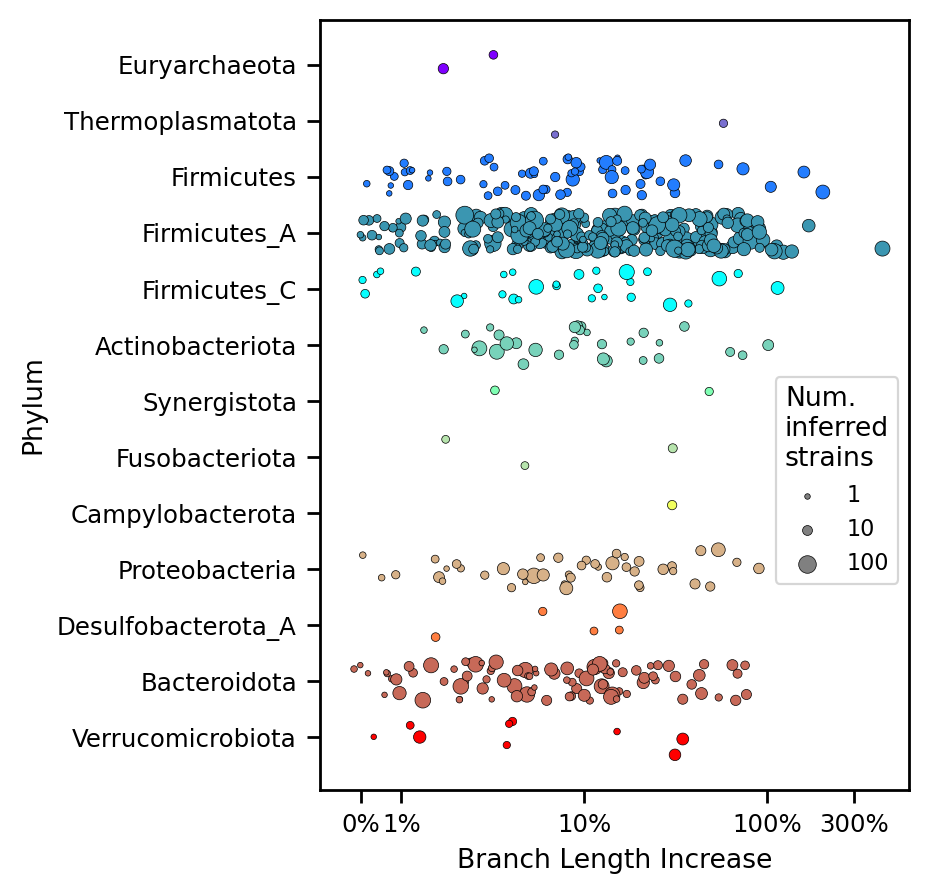

In [26]:
d = (
    # Take all genomes that have enough geno positions for relatedness estimation
    filt_stats[lambda x: x.passes_geno_positions]
    # Count the number of genomes of each type.
    [["species", "genome_id", "genome_type"]]
    .value_counts()
    .unstack(fill_value=0)
    # Tag each cluster by it's "best type"
    .assign(best_genome_type=lambda x: x[["Isolate", "MAG", "SPGC"]].idxmax(1))
    # Count for each species the number of clusters with each tag.
    .groupby("species")
    .best_genome_type.value_counts()
    .unstack(fill_value=0)
    .join(
        branch_lengths2.assign(
            branch_length_diff=lambda x: x.length_with_spgc - x.length_without_spgc,
            branch_length_ratio=lambda x: x.branch_length_diff / x.length_without_spgc,
        )
    )
    .join(
        species_prevalence.to_frame("prevalence").assign(
            mean_rabund=species_mean_rabund_when_found,
            median_rabund=species_median_rabund_when_found,
        )
    )
    .join(species_taxonomy)
    .loc[species_list1]
)

p__meta = pd.DataFrame([], index=phylum_order[::-1]).assign(
    pos=lambda x: np.arange(len(x))
)

s_func = lambda x: 4 * x**0.5

np.random.seed(42)
fig, ax = plt.subplots(figsize=(3.8, 5), facecolor="none")
ax.scatter(
    "branch_length_ratio",
    "pos_jitter",
    data=d.join(p__meta, on="p__").assign(
        pos_jitter=lambda x: x.pos + np.random.uniform(-0.35, 0.35, size=len(x)),
        c=lambda x: x.p__.map(phylum_palette),
        s=lambda x: s_func(x["SPGC"]),  # Total SPGC genomes
    ),
    # c='c',
    marker="o",
    s="s",
    facecolors="c",
    edgecolors="k",
    lw=0.25,
    alpha=1.0,
    label="__nolegend__",
)
ax.set_yticks(p__meta.pos.unique())
ax.set_yticklabels(p__meta.index.to_series().str.replace("p__", ""))
# for ytick, p__, c in zip(ax.get_yticklabels(), p__meta.index.to_series(), p__meta.index.to_series().map(phylum_palette)):
#     print(ytick, p__, c)
#     ytick.set_color(c)


ax.set_xlabel("Branch Length Increase")
ax.set_xscale("symlog", linthresh=1e-2, linscale=0.2)
ax.set_xticks([0, 0.01, 0.1, 1.0, 3.0])
ax.set_xticklabels(["0%", "1%", "10%", "100%", "300%"])
ax.set_ylabel("Phylum")
ax.set_xlim(-0.01, 6.0)  # NOTE: This is expl

# # sns.stripplot(x='p__', y='Ref_branch_frac', data=d)

for count in [1, 10, 100]:
    ax.scatter(
        [],
        [],
        edgecolor="black",
        lw=0.25,
        facecolor="grey",
        s=s_func(count),
        label=count,
    )
plt.legend(title="Num.\ninferred\nstrains", fontsize=8, bbox_to_anchor=(0.755, 0.55))

plt.savefig("fig/fig3d_branch_length.pdf", bbox_inches="tight")

Isolate  MAG  SPGC  branch_length_ratio  prevalence  mean_rabund  \
species                                                                     
102135         0   17    53             4.293469    0.330189     0.002133   
102779         0   30    39             2.025664    0.349057     0.001497   
102328         3   20    27             1.695909    0.292453     0.001882   
104234         0   16    21             1.595530    0.094340     0.001496   
102340         3   23    33             1.370906    0.377358     0.002722   
100179         5   74    43             1.231694    0.415094     0.002956   
103190         0   42    29             1.145534    0.207547     0.007023   
100086         2   18    20             1.133039    0.216981     0.002728   
101500         2   62    58             1.101648    0.669811     0.001889   
102330        10   87    27             1.061688    0.264151     0.003395   
101304         4   26    16             1.051200    0.150943     0.002086   
100111         5   17    15             1.017665    0.047170     0.001096   
102483         5   29    35             0.954278    0.226415     0.003221   
101303         9  111    19             0.947643    0.264151     0.001726   
102845         0   11     7             0.913888    0.047170     0.001509   
104129         0   42    44             0.910120    0.254717     0.005231   
101705         5   17    13             0.905096    0.103774     0.005835   
100141        10   33    49             0.899710    0.537736     0.001520   
102711         0   30    27             0.890577    0.254717     0.002147   
100989         0   14    14             0.881079    0.084906     0.019204   
100409         0   52    25             0.858080    0.226415     0.001743   
101493        12  419    68             0.819427    0.716981     0.008946   
101386         9  159    26             0.788490    0.349057     0.004705   
103335         0   34    22             0.782436    0.113208     0.001345   
102617         0   40    34             0.782285    0.283019     0.001813   
101211         0   16    11             0.773378    0.084906     0.003547   
102393         1   25    19             0.766559    0.094340     0.003714   
104267         0   11     6             0.760336    0.037736     0.024146   
102710         0   39    32             0.749426    0.188679     0.002051   
102781         0   22     9             0.748231    0.018868     0.002717   
101421         2   15    23             0.740735    0.198113     0.001407   
101258         0   22     6             0.737157    0.000000          NaN   
100259         1   48    28             0.733798    0.358491     0.001286   
100344         0   42    26             0.720627    0.207547     0.001951   
100194         1   80    32             0.713159    0.433962     0.001742   
103331         1   81     5             0.697493    0.028302     0.002522   
100169         2   30    27             0.697258    0.198113     0.002484   
101246         0  112    48             0.693554    0.537736     0.001944   
100873         0   20     7             0.691606    0.056604     0.005108   
102508         2   10     5             0.685873    0.009434     0.004236   

         median_rabund          d__                  p__  \
species                                                    
102135        0.001125  d__Bacteria      p__Firmicutes_A   
102779        0.001048  d__Bacteria        p__Firmicutes   
102328        0.001228  d__Bacteria      p__Firmicutes_A   
104234        0.001345  d__Bacteria        p__Firmicutes   
102340        0.001660  d__Bacteria      p__Firmicutes_A   
100179        0.001635  d__Bacteria      p__Firmicutes_A   
103190        0.001559  d__Bacteria      p__Firmicutes_C   
100086        0.001838  d__Bacteria      p__Firmicutes_A   
101500        0.001175  d__Bacteria      p__Firmicutes_A   
102330        0.001674  d__Bacteria      p__Firmicutes_A   
101304        0.001569  d__Bacteria        p__Firmicut

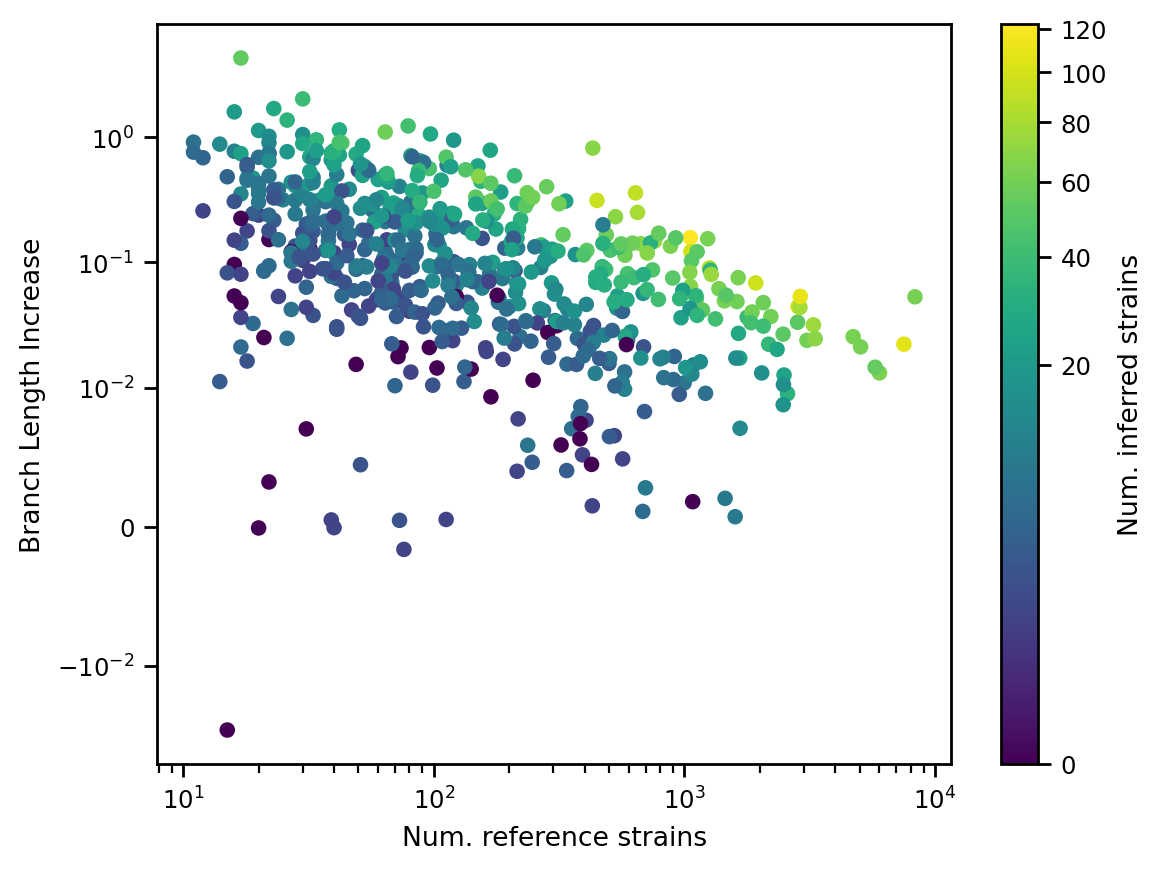

In [27]:
d = (
    # Take all genomes that have enough geno positions for relatedness estimation
    filt_stats[lambda x: x.passes_geno_positions]
    # Count the number of genomes of each type.
    [["species", "genome_id", "genome_type"]]
    .value_counts()
    .unstack(fill_value=0)
    # Tag each cluster by it's "best type"
    .assign(best_genome_type=lambda x: x[["Isolate", "MAG", "SPGC"]].idxmax(1))
    # Count for each species the number of clusters with each tag.
    .groupby("species")
    .best_genome_type.value_counts()
    .unstack(fill_value=0)
    .join(
        branch_lengths2.assign(
            branch_length_diff=lambda x: x.length_with_spgc - x.length_without_spgc,
            branch_length_ratio=lambda x: x.branch_length_diff / x.length_without_spgc,
        )
    )
    .join(
        species_prevalence.to_frame("prevalence").assign(
            mean_rabund=species_mean_rabund_when_found,
            median_rabund=species_median_rabund_when_found,
        )
    )
    .join(species_taxonomy)
    .loc[species_list1]
)

plt.scatter(
    d.num_ref, d.branch_length_ratio, c=d.num_spgc, norm=mpl.colors.PowerNorm(1 / 3)
)
plt.colorbar(label="Num. inferred strains")
plt.yscale("symlog", linthresh=1e-2)
plt.xscale("log")
plt.xlabel("Num. reference strains")
plt.ylabel("Branch Length Increase")

d[
    [
        "Isolate",
        "MAG",
        "SPGC",
        "branch_length_ratio",
        "prevalence",
        "mean_rabund",
        "median_rabund",
        "d__",
        "p__",
        "c__",
        "o__",
        "f__",
        "g__",
        "s__",
    ]
].sort_values("branch_length_ratio", ascending=False).head(40)

In [28]:
d = branch_lengths2.assign(
    branch_length_diff=lambda x: x.length_with_spgc - x.length_without_spgc,
    branch_length_ratio=lambda x: x.branch_length_diff / x.length_without_spgc,
).branch_length_ratio
for thresh in [0.1, 0.2, 0.5]:
    print(thresh, (d > thresh).sum())

0.1 288
0.2 183
0.5 63


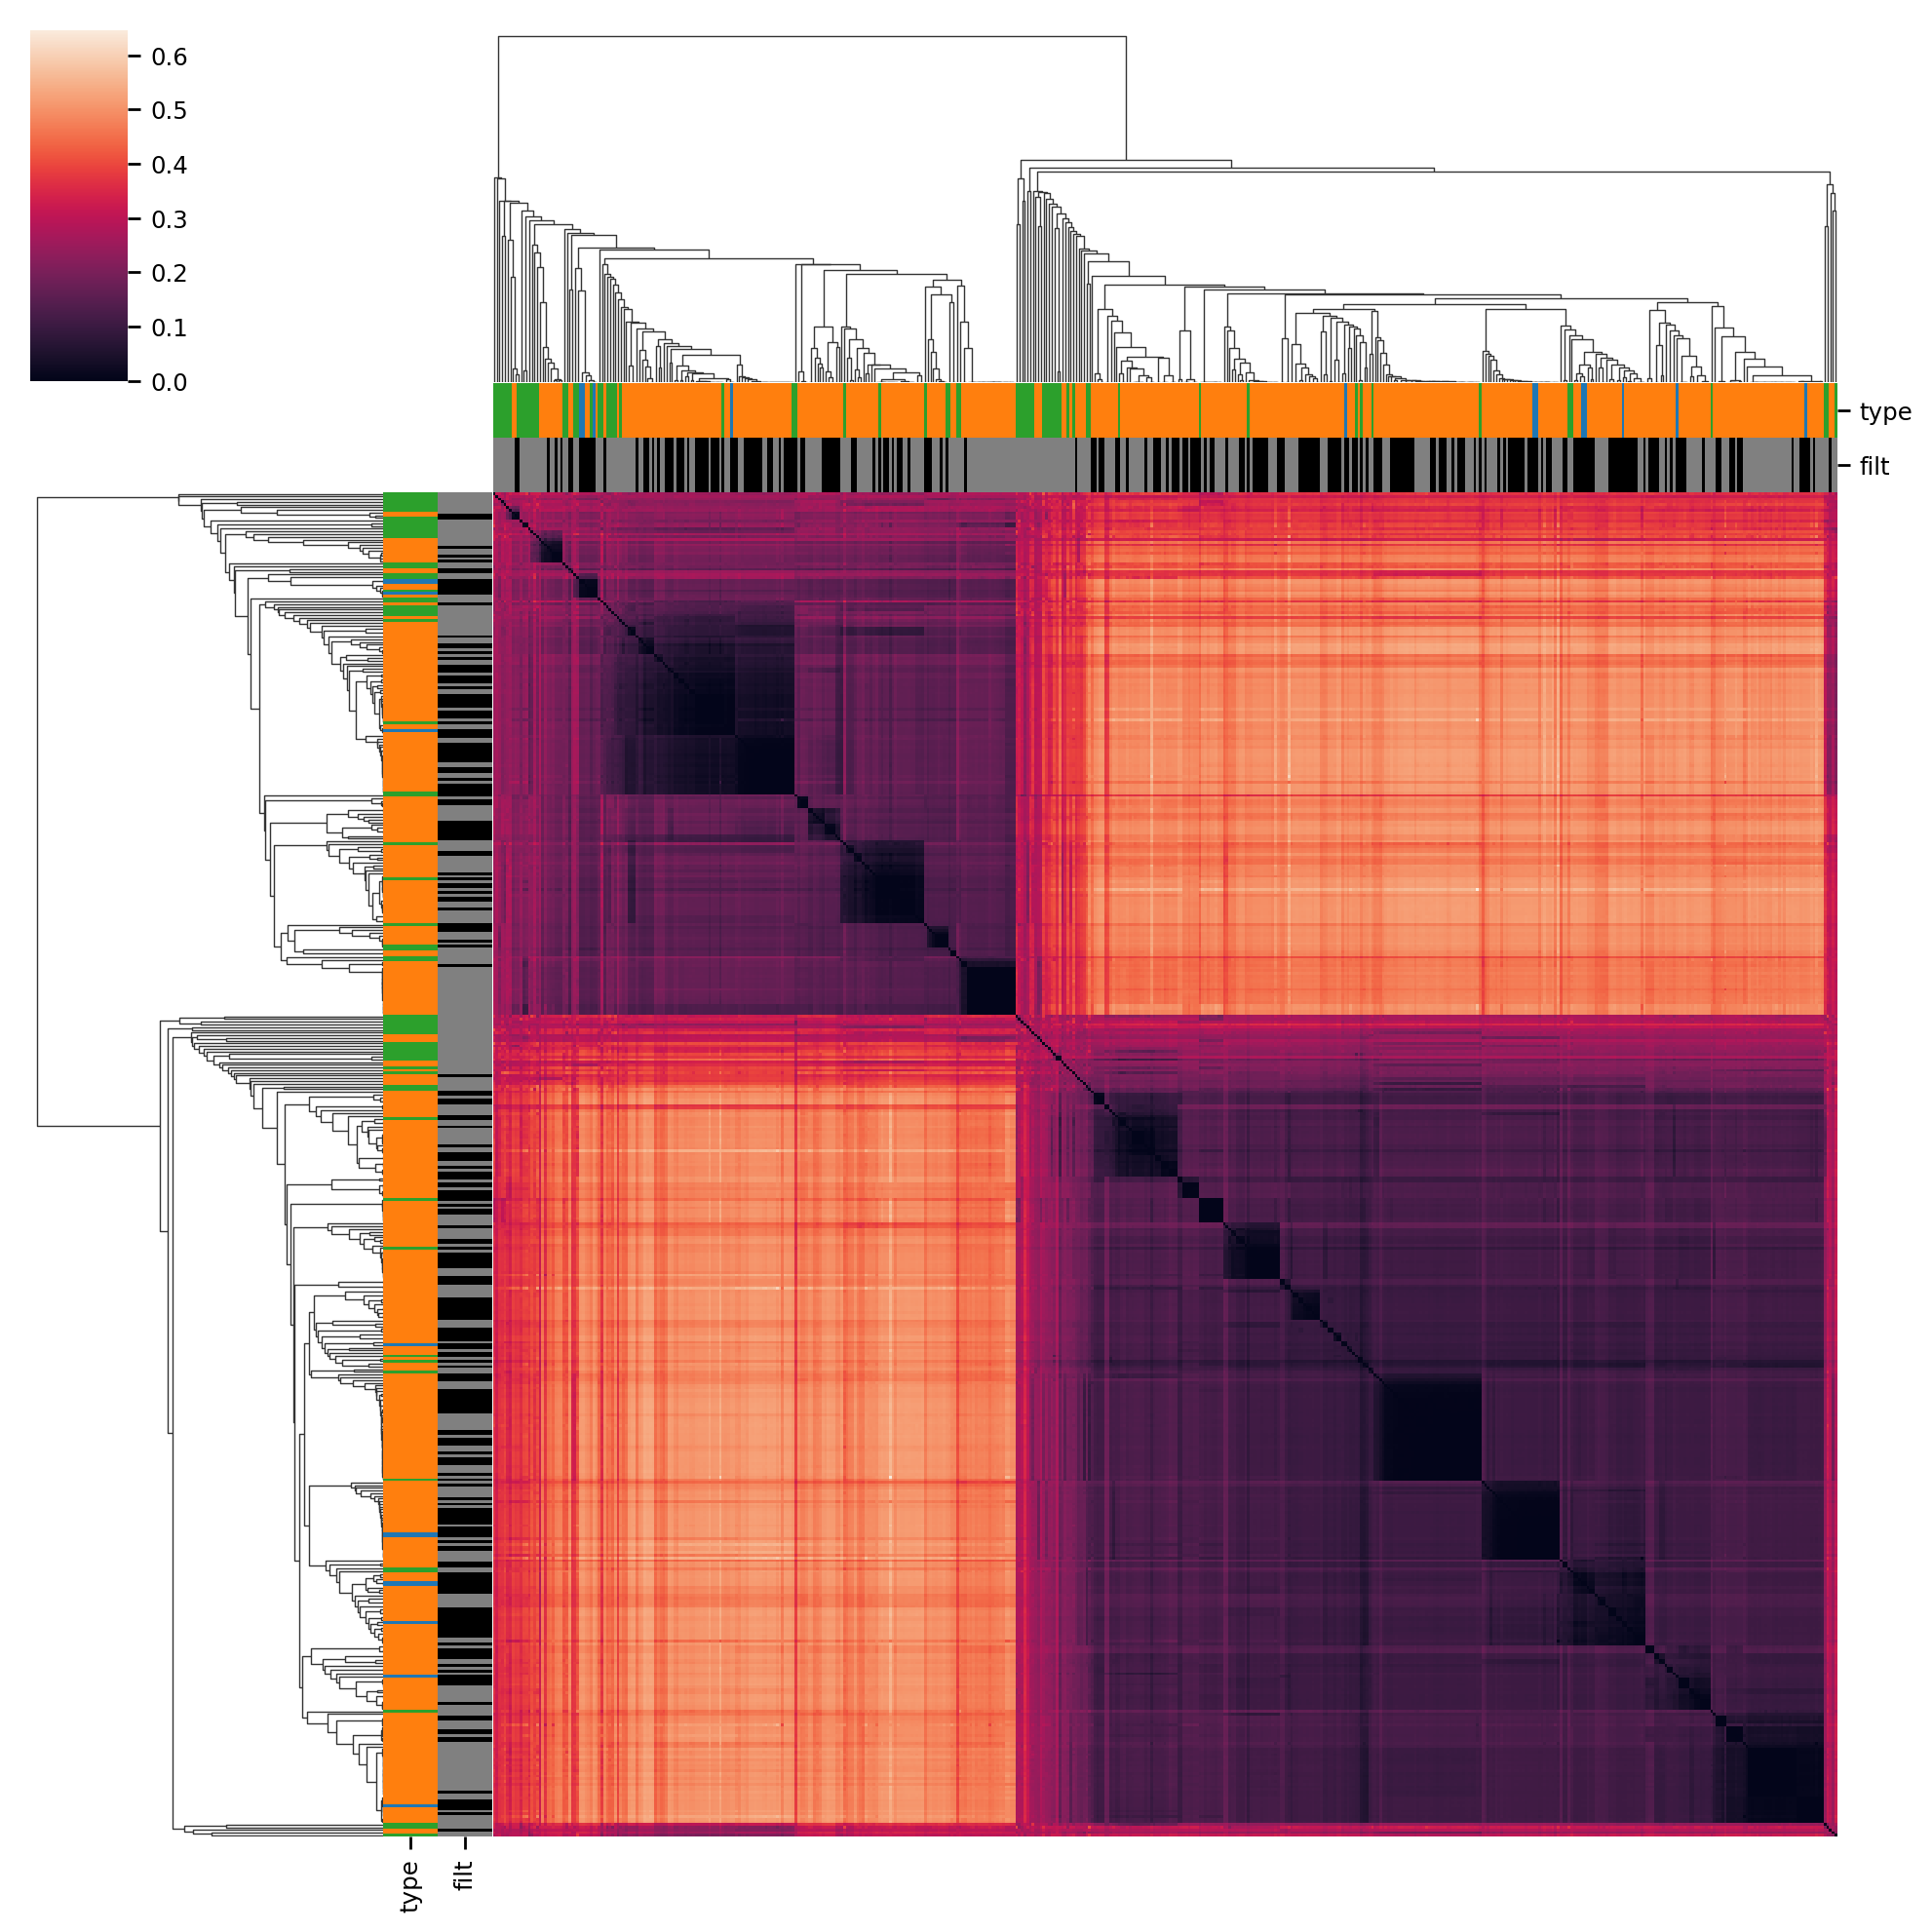

In [29]:
species = "101493"

spgc_meta = pd.read_table(
    f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv",
    index_col="genome_id",
)
spgc_data = xr.load_dataset(
    f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.nc"
)
mgtp_diss_all = lib.dissimilarity.load_dmat_as_pickle(
    f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.spgc_ss-all.geno_uhgg-v20_pdist-mask10-pseudo10.pkl"
)

mgtp_diss = mgtp_diss_all.loc[
    spgc_meta.passes_geno_positions, spgc_meta.passes_geno_positions
]
mgtp_linkage = sp.cluster.hierarchy.linkage(
    squareform(mgtp_diss), method="average", optimal_ordering=False
)

_colors = pd.DataFrame(
    dict(
        type=spgc_meta.genome_type.map(genome_type_palette),
        filt=spgc_meta.passes_filter.map({True: "black", False: "grey"}),
    )
)
sns.clustermap(
    mgtp_diss,
    row_colors=_colors,
    col_colors=_colors,
    row_linkage=mgtp_linkage,
    col_linkage=mgtp_linkage,
    figsize=(10, 10),
    xticklabels=0,
    yticklabels=0,
)

In [30]:
w = sf.data.World.load(
    f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.world.nc"
)
position_ss = w.random_sample(position=1500).position
sf.plot.plot_metagenotype(
    w.sel(position=position_ss), col_linkage_func=lambda w: w.metagenotype.linkage()
)
sf.plot.plot_community(
    w.sel(position=position_ss), col_linkage_func=lambda w: w.metagenotype.linkage()
)

/include/StrainFacts/sfacts/math.py:25: RuntimeWarning: invalid value encountered in scalar divide
  wmean_dist = (weight * dist).sum() / weight.sum()
/include/StrainFacts/sfacts/plot.py:163: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)
/include/StrainFacts/sfacts/math.py:25: RuntimeWarning: invalid value encountered in scalar divide
  wmean_dist = (weight * dist).sum() / weight.sum()
/include/StrainFacts/sfacts/plot.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(row_col_annotation_cmap)


### Genotype Dissimilarity to Closest Reference

In [31]:
# This inlined calculation of genotype dissimilarity is necessary because the diss_stats are incomplete where no strains pass filtering.
min_geno_diss = {}
missing_species = []

_species_list = species_list1  # NOT Species list #2, here we're looking at the overall diversity of genotypes identified.
# _species_list = ["100003"]

for species in tqdm(_species_list):
    _spgc_list = filt_stats[
        lambda x: (x.species == species)
        & x.genome_type.isin(["SPGC"])
        & x.passes_geno_positions
    ].genome_id
    _ref_list = filt_stats[
        lambda x: (x.species == species)
        & x.genome_type.isin(["Isolate", "MAG"])
        & x.passes_geno_positions
    ].genome_id
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.spgc_ss-all.geno_uhgg-v20_pdist-mask10-pseudo10.pkl"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    min_geno_diss[species] = (
        load_dmat_as_pickle(inpath)
        .loc[_ref_list, _spgc_list]
        .min()
        .to_frame()
        .assign(species=species)
    )

min_geno_diss = (
    pd.concat(min_geno_diss.values())
    .rename(columns={0: "min_geno_diss"})
    .rename_axis(index="strain")
    .reset_index()
    .set_index(["species", "strain"])
    .min_geno_diss
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 601/601 [00:39<00:00, 15.21it/s]


0.08059515460216057 0.680259076810801


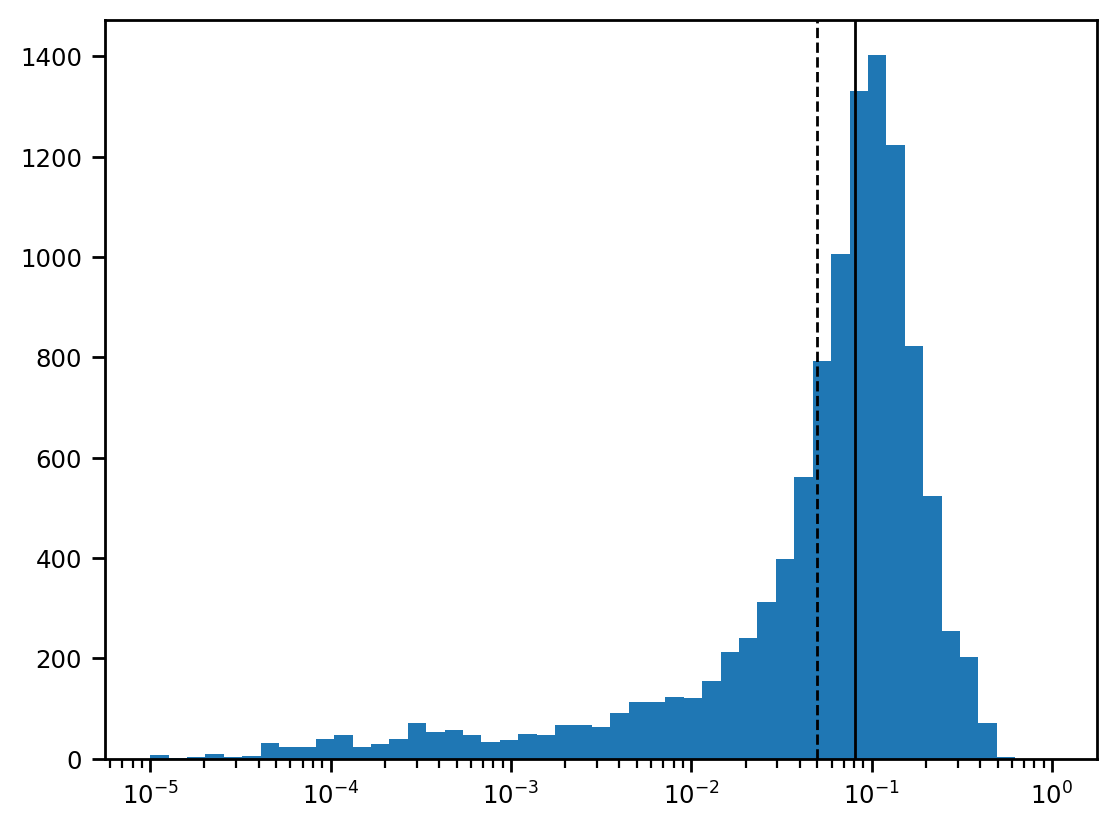

In [32]:
bins = np.logspace(-5, 0, num=50)
plt.hist(min_geno_diss, bins=bins)
plt.axvline(0.05, lw=1, linestyle="--", color="k")
plt.axvline(min_geno_diss.median(), lw=1, linestyle="-", color="k")

plt.xscale("log")

print(min_geno_diss.median(), (min_geno_diss > 0.05).mean())

### Gene Content Dissimilarity to Closest Reference

In [33]:
diss_stats.ref_nn_uhgg_diss.reindex(spgc_strain_list2).dropna().median()

0.1794557166076071

## Relationship between Genotype and Gene Content Dissimilarity

### Overall

In [34]:
d0 = (
    diss_stats.reindex(spgc_strain_list3)  # >= 10 strains
    .dropna(subset=["min_ref_geno_diss", "ref_nn_uhgg_diss"])
    .assign(log_min_ref_geno_diss=lambda x: np.log10(x.min_ref_geno_diss))
)

diss_corr = []
for species in d0.species.unique():
    d1 = d0[lambda x: x.species == species]
    diss_corr.append(
        (
            species,
            *sp.stats.spearmanr(
                d1.min_ref_geno_diss, d1.min_ref_eggnog_diss, alternative="greater"
            ),
            d1.min_ref_geno_diss.std(),
            len(d1),
        )
    )

diss_corr = pd.DataFrame(
    diss_corr,
    columns=["species", "spearmanr", "pvalue", "geno_diss_stdev", "num_strains"],
)
diss_corr.spearmanr.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05   -0.264848
0.25    0.079977
0.50    0.274783
0.75    0.474060
0.95    0.687775
Name: spearmanr, dtype: float64

SignificanceResult(statistic=0.347539726469585, pvalue=0.0004241299645275746)

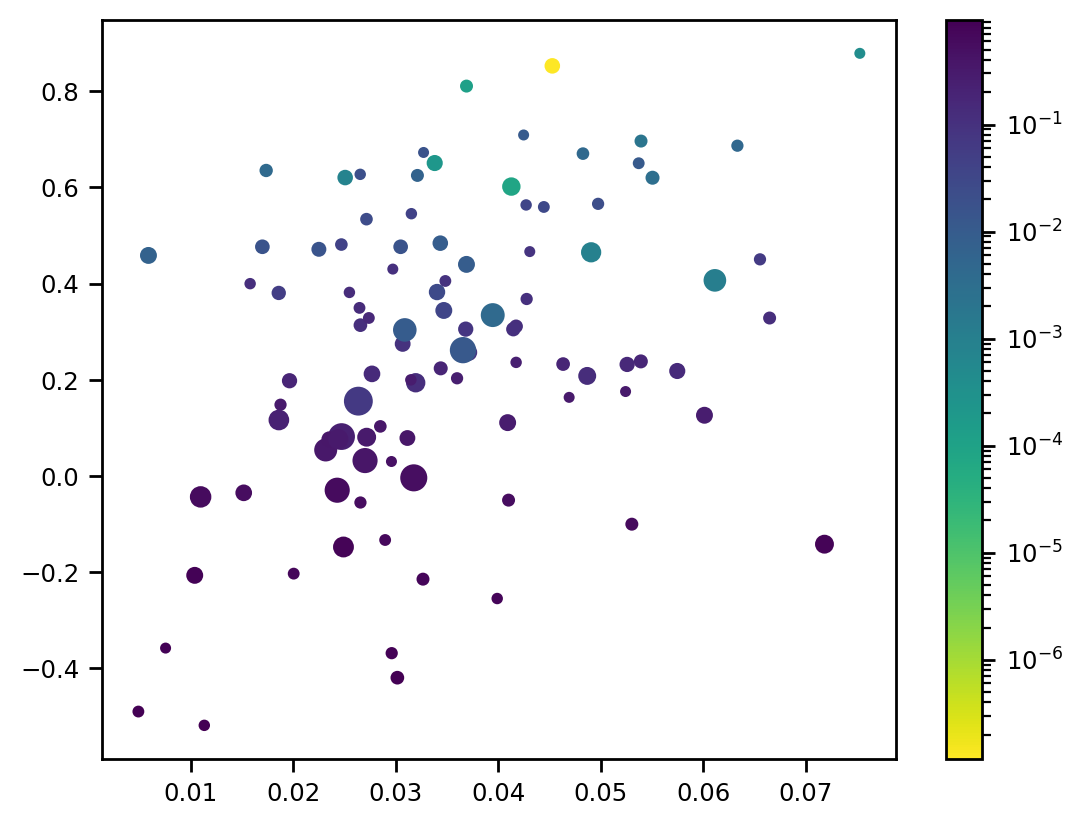

In [35]:
plt.scatter(
    "geno_diss_stdev",
    "spearmanr",
    data=diss_corr,
    c="pvalue",
    norm=mpl.colors.LogNorm(),
    cmap="viridis_r",
    s="num_strains",
)
plt.colorbar()

sp.stats.spearmanr(diss_corr.geno_diss_stdev, diss_corr.spearmanr)

In [36]:
(diss_corr.pvalue < 0.05).sum()

35

### E. coli

28


SignificanceResult(statistic=0.438423645320197, pvalue=0.01961134685374843)

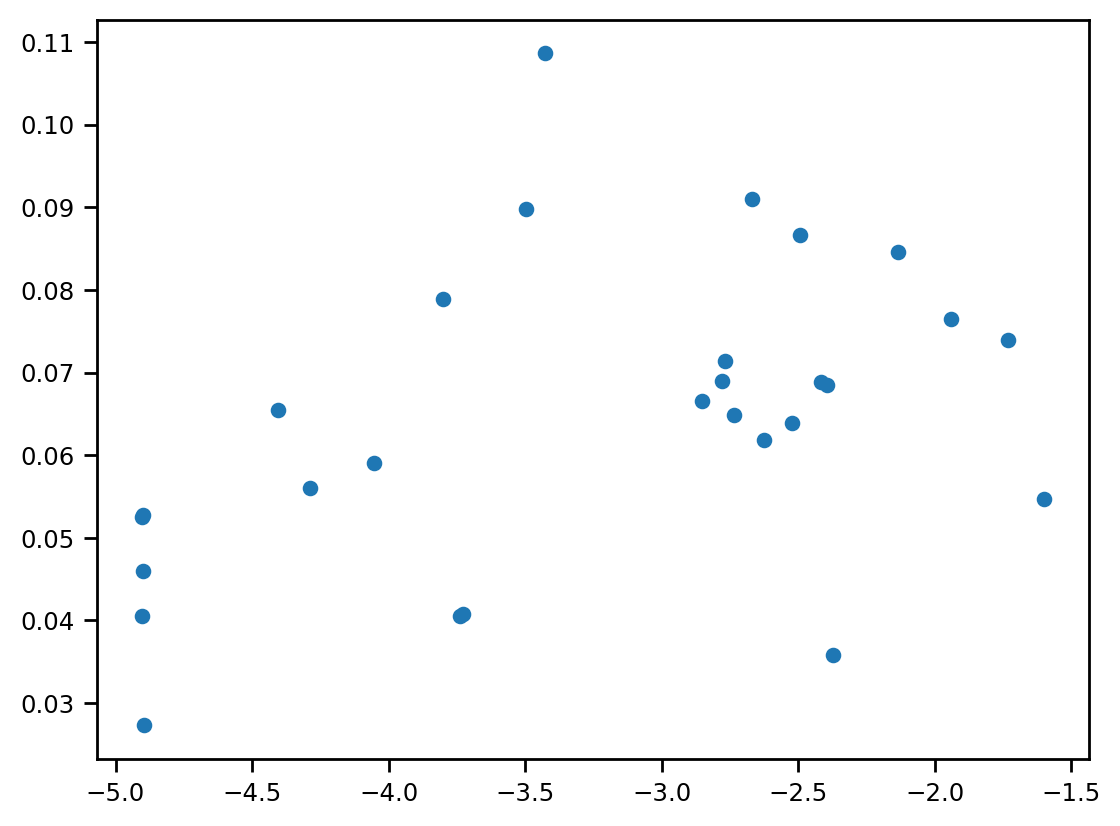

In [37]:
d0 = (
    diss_stats.reindex(spgc_strain_list2)
    .dropna(subset=["min_ref_geno_diss", "ref_nn_uhgg_diss"])
    .assign(log_min_ref_geno_diss=lambda x: np.log10(x.min_ref_geno_diss))
)
d1 = d0[lambda x: x.species == "102506"]
print(d1.shape[0])
plt.scatter(d1["log_min_ref_geno_diss"], d1["ref_nn_eggnog_diss"])
sp.stats.spearmanr(d1["min_ref_geno_diss"], d1["ref_nn_eggnog_diss"])

### Figure 3F

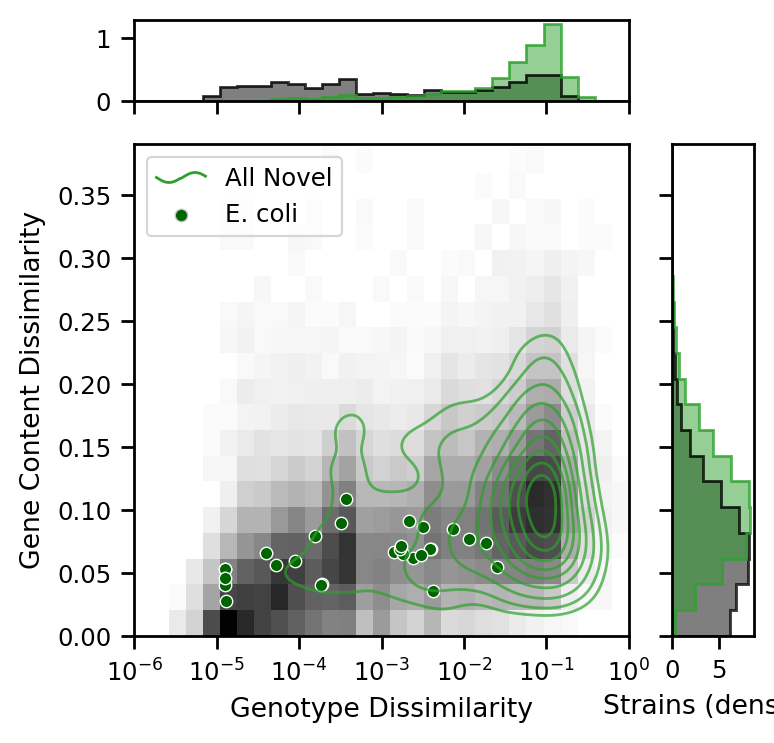

In [38]:
import matplotlib.ticker as mtick

d = diss_stats[lambda x: x.passes_filter].assign(
    log_min_ref_geno_diss=lambda x: np.log10(x.min_ref_geno_diss)
)
d_ref = d[lambda x: x.genome_type.isin(["Isolate", "MAG"])]
d_spgc = d[lambda x: x.genome_type.isin(["SPGC"])]
x_bins = np.linspace(
    -6,
    0,
    num=30,
)
y_bins = np.linspace(0, 1)

fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw=dict(
        width_ratios=(3, 0.5), height_ratios=(0.5, 3), hspace=0.15, wspace=0.15
    ),
    sharex="col",
    sharey="row",
    figsize=(4, 4),
)

axs[1, 0].hist2d(
    "log_min_ref_geno_diss",
    "ref_nn_eggnog_diss",
    data=d_ref,
    bins=(x_bins, y_bins),
    norm=mpl.colors.PowerNorm(1 / 2, vmax=3000),
    cmap="binary",
)
# axs[1, 0].scatter('log_min_ref_geno_diss', 'ref_nn_eggnog_diss', data=d_spgc, s=0.5, alpha=1.0, color=genome_type_palette['SPGC'])
# sns.kdeplot(x='log_min_ref_geno_diss', y='ref_nn_eggnog_diss', data=d_ref.sample(n=100), color=genome_type_palette['Ref'], ax=axs[1, 0], linewidths=1, levels=np.linspace(0, 1, num=11))
sns.kdeplot(
    x="log_min_ref_geno_diss",
    y="ref_nn_eggnog_diss",
    data=d_spgc,
    color=genome_type_palette["SPGC"],
    ax=axs[1, 0],
    linewidths=1,
    levels=np.linspace(0, 1, num=11),
    alpha=0.7,
)
focal_species, focal_species_label = "102506", "E. coli"
axs[1, 0].scatter(
    "log_min_ref_geno_diss",
    "ref_nn_eggnog_diss",
    data=d_spgc[lambda x: x.species == focal_species],
    color="darkgreen",
    s=20,
    edgecolor="white",
    linewidth=0.5,
    label="__nolegend__",
)
axs[1, 0].set_xlabel("Genotype Dissimilarity")
axs[1, 0].set_ylabel("Gene Content Dissimilarity")
axs[1, 0].set_ylim(0, 0.39)

# Legend
with mpl.rc_context({"path.sketch": (5, 50, 1)}):
    axs[1, 0].plot([], [], lw=1, label="All Novel", color=genome_type_palette["SPGC"])
axs[1, 0].scatter(
    [],
    [],
    color="darkgreen",
    s=20,
    edgecolor="silver",
    linewidth=0.5,
    label=focal_species_label,
)
axs[1, 0].legend(loc="upper left")

axs[1, 1].hist(
    "ref_nn_eggnog_diss",
    data=d_ref,
    orientation="horizontal",
    bins=y_bins,
    histtype="step",
    alpha=0.8,
    lw=1,
    color=genome_type_palette["Ref"],
    density=True,
    label="__nolegend__",
)
axs[1, 1].hist(
    "ref_nn_eggnog_diss",
    data=d_ref,
    orientation="horizontal",
    bins=y_bins,
    histtype="stepfilled",
    alpha=0.5,
    color=genome_type_palette["Ref"],
    density=True,
    label="Reference",
)
axs[1, 1].hist(
    "ref_nn_eggnog_diss",
    data=d_spgc,
    orientation="horizontal",
    bins=y_bins,
    histtype="step",
    alpha=0.8,
    lw=1,
    color=genome_type_palette["SPGC"],
    density=True,
    label="__nolegend__",
)
axs[1, 1].hist(
    "ref_nn_eggnog_diss",
    data=d_spgc,
    orientation="horizontal",
    bins=y_bins,
    histtype="stepfilled",
    alpha=0.5,
    color=genome_type_palette["SPGC"],
    density=True,
    label="Novel",
)
# axs[1, 1].set_xticks([0])
axs[1, 1].set_xlabel("Strains (density)")
# axs[1, 1].legend(bbox_to_anchor=(1, 1))


axs[0, 0].hist(
    "log_min_ref_geno_diss",
    data=d_ref,
    orientation="vertical",
    bins=x_bins,
    histtype="step",
    alpha=0.8,
    lw=1,
    color=genome_type_palette["Ref"],
    density=True,
    label="__nolegend__",
)
axs[0, 0].hist(
    "log_min_ref_geno_diss",
    data=d_ref,
    orientation="vertical",
    bins=x_bins,
    histtype="stepfilled",
    alpha=0.5,
    color=genome_type_palette["Ref"],
    density=True,
    label="Reference",
)
axs[0, 0].hist(
    "log_min_ref_geno_diss",
    data=d_spgc,
    orientation="vertical",
    bins=x_bins,
    histtype="step",
    alpha=0.8,
    lw=1,
    color=genome_type_palette["SPGC"],
    density=True,
    label="__nolegend__",
)
axs[0, 0].hist(
    "log_min_ref_geno_diss",
    data=d_spgc,
    orientation="vertical",
    bins=x_bins,
    histtype="stepfilled",
    alpha=0.5,
    color=genome_type_palette["SPGC"],
    density=True,
    label="Novel",
)
# axs[0, 0].set_yticks([0])
# axs[0, 0].set_ylabel('Strains (density)')
# axs[0, 0].legend(bbox_to_anchor=(1, 1))

# axs[0, 0].set_ylabel('dens.')

axs[1, 0].xaxis.set_major_formatter(mtick.FormatStrFormatter("$10^{%d}$"))


lib.plot.hide_axes_and_spines(axs[0, 1])

# fig.savefig('fig/spgc_genotype_gene_content_joint_distributions.svg', bbox_inches='tight')
sp.stats.spearmanr(
    d_spgc[lambda x: x.species == focal_species].min_ref_geno_diss,
    d_spgc[lambda x: x.species == focal_species].ref_nn_eggnog_diss,
)

plt.savefig("fig/fig3f_closest_reference.pdf", bbox_inches="tight")

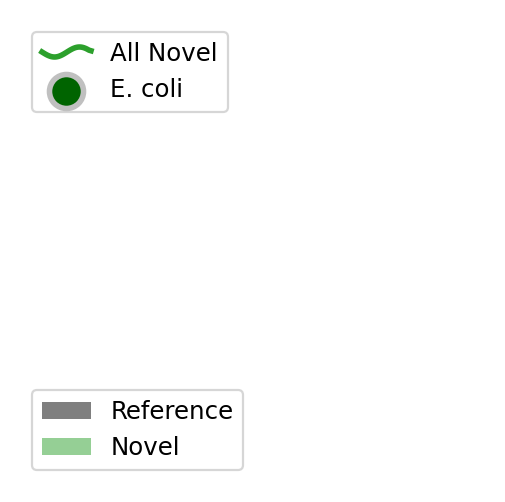

In [39]:
fig, ax1 = plt.subplots(figsize=(3, 3), facecolor="none")

ax2 = ax1.twinx()

# Legend
with mpl.rc_context({"path.sketch": (5, 50, 1)}):
    ax1.plot([], [], lw=2, label="All Novel", color=genome_type_palette["SPGC"])
ax1.scatter(
    [],
    [],
    color="darkgreen",
    s=150,
    edgecolor="silver",
    linewidth=2,
    label=focal_species_label,
)
ax1.legend(loc="upper left", facecolor="none")
lib.plot.hide_axes_and_spines(ax=ax1)

ax2.hist(
    [],
    histtype="stepfilled",
    alpha=0.5,
    color=genome_type_palette["Ref"],
    label="Reference",
)
ax2.hist(
    [],
    histtype="stepfilled",
    alpha=0.5,
    color=genome_type_palette["SPGC"],
    label="Novel",
)
ax2.legend(loc="lower left", facecolor="none")
lib.plot.hide_axes_and_spines(ax=ax2)

/pollard/data/projects/bsmith/strain-corr/lib/plot.py:502: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


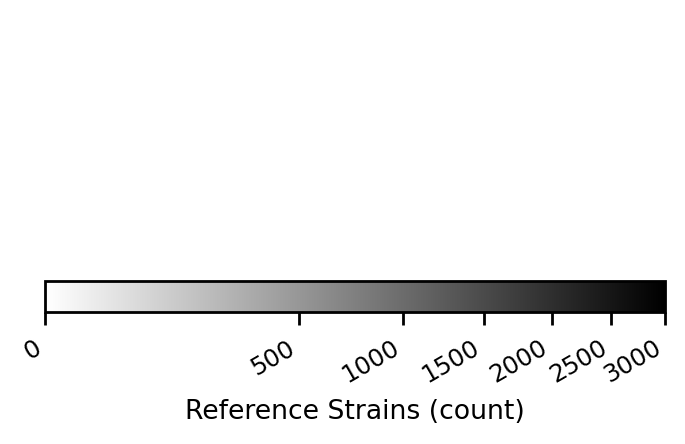

In [40]:
fig = plt.figure(figsize=(4, 2), facecolor="none")
x, _, _, _ = plt.hist2d(
    [], [], norm=mpl.colors.PowerNorm(1 / 2, vmin=0, vmax=3000), cmap="binary"
)
ax2 = plt.colorbar(label="Reference Strains (count)", orientation="horizontal")
lib.plot.hide_axes_and_spines()
lib.plot.rotate_xticklabels(ax2.ax, rotation=30)
# plt.tight_layout()

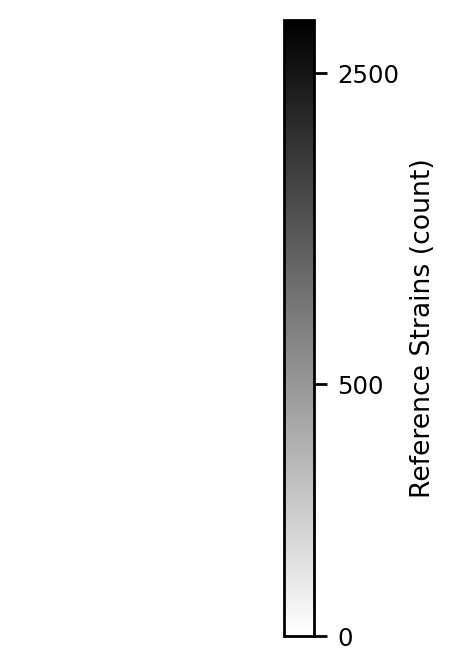

In [41]:
fig = plt.figure(figsize=(2, 4), facecolor="none")
x, _, _, _ = plt.hist2d(
    [], [], norm=mpl.colors.PowerNorm(1 / 2, vmin=0, vmax=3000), cmap="binary"
)
ax2 = plt.colorbar(label="Reference Strains (count)", ticks=[0, 500, 2500])
lib.plot.hide_axes_and_spines()
lib.plot.rotate_xticklabels(ax2.ax, rotation=30)
# plt.tight_layout()

fig.savefig(
    "fig/spgc_genotype_gene_content_joint_distributions_colorbar.svg",
    bbox_inches="tight",
)